In [ ]:
import re
import json
import editdistance
import numpy as np
import pandas as pd

from unidecode import unidecode
from tqdm import tqdm
from typing import List, Tuple, Union

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

from flair.data import Sentence
from flair.models import SequenceTagger, TextClassifier
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')


class Character:
    """
    Extract characters from reviews and the sentiment corresponding
    to the sentences from which the characters were extracted. This way,
    you can analyze how positive/negative people are about certain characters.

    NOTE: This works better for actual people than the characters from movies
    or animations. Often, reviewers describe what happens in movies to certain
    characters which could be negative of nature, while it was not intended as
    a negative opinion of that character. Thus, it combines both descriptive events
    as well as opinions. However, since the actors themselves are not played in the movie,
    the sentences in which actors appear are typically of an opinionated nature.

    Parameters:
    -----------
    fast : bool, default = True
        Whether to use a cpu-based BERT classifier and tagger

    dir_path : str
        The path of the cwd, keep empty if there are no
        files to be saved in a parent dir

    """
    def __init__(self, load_classifiers=True, fast=False, dir_path: str = ""):
        if load_classifiers:
            if fast:
                self.tagger = SequenceTagger.load('ner-fast')
                self.classifier = TextClassifier.load('sentiment-fast')
            else:
                self.tagger = SequenceTagger.load('ner')
                self.classifier = TextClassifier.load('sentiment')

        self.dir_path = dir_path
        self.reviews_path = None
        self.reviews = None
        self.titles = None
        self.names = None
        self.processed_names = None

    def predict_single_movie(self, name: str, reviews: List[str]) -> List[Tuple[str, int, str]]:
        """ Create predictions for a single movie


        Parameters
        ----------
        name : str
            Name of the movie

        reviews : list of str
            A list of reviews


        Returns
        -------
        results : list of tuples
            A list where each item is a tuple of the text, score and value if it is
            classified as "PER"

        """
        new_docs = [sent_tokenize(doc) for doc in reviews]
        new_docs = [x for sublist in new_docs for x in sublist]
        new_docs = [Sentence(x) for x in new_docs]

        self.tagger.predict(new_docs, verbose=False)
        self.classifier.predict(new_docs, verbose=False)

        results = []
        for sentence in new_docs:
            for token in sentence.get_spans('ner'):
                if token.tag == "PER":
                    results.append((token.text, sentence.get_labels()[0].score, sentence.get_labels()[0].value))

        with open(f'{self.dir_path}{name}.json', 'w') as f:
            json.dump(results, f)

        return results

    def load_reviews(self, reviews_path: str, names_path: str = None):
        """ Load reviews and the corresponding titles

        Parameters
        ----------
        reviews_path : str
            The path of the review location.
            E.g. : disney_reviews.json

        names_path : str, default None
            Whether to also extract the names if they were previously extracted
        """
        if reviews_path:
            self.reviews_path = reviews_path
            with open(f'{self.dir_path}{self.reviews_path}') as f:
                self.reviews = json.load(f)
            self.titles = [(title, re.sub('[^a-zA-Z]+', '', title).lower()) for title in list(self.reviews.keys())]

        if names_path:
            with open(f'{self.dir_path}{names_path}') as f:
                self.names = json.load(f)

    def predict(self, path: str, prefix: str) -> dict:
        """ For each movie in path


        Parameters
        ----------
        path : str
            The path of the review location.
            E.g. : disney_reviews.json

        prefix : str
            Prefix for the file you want saved

        Returns
        -------
        to_save : dict
            Title (key) and results (value) for each movie
        """
        self.load_reviews(path)

        # Generate predictions
        results = {title: None for title in self.titles}
        for title, name in tqdm(self.titles):
            results[title] = self.predict_single_movie(name, self.reviews[title])

        # Save results - make sure correct format is used
        self.names = {title: results[title] for title, _ in self.titles}

        with open(f'{self.dir_path}{prefix}_names.json', 'w') as f:
            json.dump(self.names, f)

        return self.names

    def preprocess_names_and_reviews(self, reviews_path: str = None, names_path: str = None):
        """

        Parameters
        ----------
        reviews_path : str, default None
            The path of the reviews json file. If None, then use the
            reviews already loaded within this class.

        names_path : str, default None
            The path of the names json file. If None, then use the
            names already loaded within this class.
        """
        self.load_reviews(reviews_path, names_path)
        sentences_per_movie = {title: get_nr_sentences(self.reviews[title]) for title in self.reviews}
        self.processed_names = {title: preprocess_names(self.names[title],
                                                        sentences_per_movie[title],
                                                        title) for
                                title in self.names}

    def visualize_names(self, name, people=False, save=None):
        if not self.processed_names:
            raise Exception("Please preprocess the names from the reviews first through: \n"
                            "character.preprocess_names_and_reviews('reviews.json', 'names.json')")

        if name not in self.processed_names.keys():
            names = list(self.processed_names.keys())
            raise Exception(f"Please select one of the following names: {names}")

        df = self.processed_names[name]
        if people:
            df = df.loc[df.Nr_Words > 1, :]

        plt.figure(figsize=(12, 5))
        norm = TwoSlopeNorm(vmin=-1, vcenter=0.0,
                            vmax=1)
        colors = [plt.cm.bwr(norm(c)) for c in df.Sentiment.head(15)]
        ax = sns.barplot(x='Sentiment', y='Word', data=df.head(15), palette=colors, edgecolor='black')
        plt.tight_layout()
        plt.xlabel("Sentiment")
        plt.ylabel("")

        if save:
            plt.savefig(f"../images/{save}.png", dpi=300)
        else:
            plt.show()


def get_nr_sentences(docs: List[str]) -> int:
    """ Extract nr of sentences from a list of documents """
    total_nr_sentences = 0
    for doc in docs:
        sentences = sent_tokenize(doc)
        total_nr_sentences += len(sentences)
    return total_nr_sentences


def preprocess_names(names: List[List[Union[str, float, str]]], nr_sentences: int, title: str) -> pd.DataFrame:
    """ From a list of names and sentiment, extract the most popular characters
    and their respective average sentiment.

    Parameters
    ----------
    names : List[List[str, float, str]]
        For each movie, contains a list of names, their sentiment, and its probability score.

        If you have extracted the movie Cars, then names could be:

        [['George Jones', 0.9976274371147156, 'POSITIVE'],
         ['Wilson', 0.9992721676826477, 'POSITIVE'],
         ['Newman', 0.9992721676826477, 'POSITIVE'],
         ["Joe DiMaggio's", 0.9988816380500793, 'POSITIVE'],
         ['Lightning McQueen', 0.9817501306533813, 'POSITIVE'],
         ['Lightning McQueen', 0.9990585446357727, 'POSITIVE'],
         ['Owen Wilson),', 0.9990585446357727, 'POSITIVE']]

    nr_sentences : int
        The total number of sentences in the extracted reviews for this movie

    title : str
        The name of the movie to make sure the character is not in the name of the movie.
        The result would be a much higher count of the character as it should be.
    """
    df = pd.DataFrame(names, columns=["Word", "Prob", "Sentiment"])

    # Preprocessing - Only keep high probabilities and general cleaning
    df.Sentiment = df.Sentiment.map({"POSITIVE": 1, "NEGATIVE": -1})
    df.Word = [unidecode(word) for word in df.Word]
    df.Word = df.Word.str.replace('[^A-z]', ' ').str.strip()
    df.Word = [re.sub(r"\b[a-zA-Z]\b", "", word).strip() for word in df.Word.values]
    df = df.loc[df.Word != "Disney", :]
    df = df.loc[df.Word.str.len() >= 3, :]
    df = df.loc[df.Prob > 0.9, :]
    df = preprocess_titles(df)

    # Finishing up - Average all results and create a general overview of common persons
    df = df.groupby("Word").agg({"Sentiment": [np.mean, np.count_nonzero]})
    df.columns = df.columns.droplevel()
    df = df.reset_index()
    df.columns = ["Word", "Sentiment", "Count"]
    df["Count_Percentage"] = df.Count / nr_sentences * 100
    df["Title"] = title
    df = df.sort_values("Count", ascending=False)
    df["Nr_Words"] = df.apply(lambda row: len(row.Word.split(" ")), 1)

    return df


def preprocess_titles(df: pd.DataFrame) -> pd.DataFrame:
    """ Preprocess the titles such that they are mapped to each other
    if the edit distance is 2 or lower

    Parameters
    ----------
    df : pd.DataFrame
        The dataframe that includes the words/names by the column "Words"

    Returns
    -------
    df : pd.DataFrame
        The cleaned up dataframe
    """

    # Extract frequency of words
    grouped = df.groupby("Word").count().reset_index().sort_values("Prob", ascending=False)
    count = list(zip(grouped.Word.values, grouped.Prob.values))

    # From low frequent words to high frequent words, map low frequent words
    # to higher frequent words if the edit distance is 2 or lower.
    to_map = {}
    for index, (search_word, search_count) in enumerate(count[::-1]):
        for result_word, result_count in count[::-1][index + 1:]:
            val = editdistance.eval(search_word, result_word)

            if val != 0:
                if val <= 2 and result_count > search_count:
                    to_map[search_word] = result_word

    # Apply the mapping
    for key, value in to_map.items():
        df.loc[df.Word == key, "Word"] = value

    return df

In [2]:
char = Character(load_classifiers=False)

In [3]:
char.preprocess_names_and_reviews("../data/disney_reviews.json", "../data/disney_names.json")

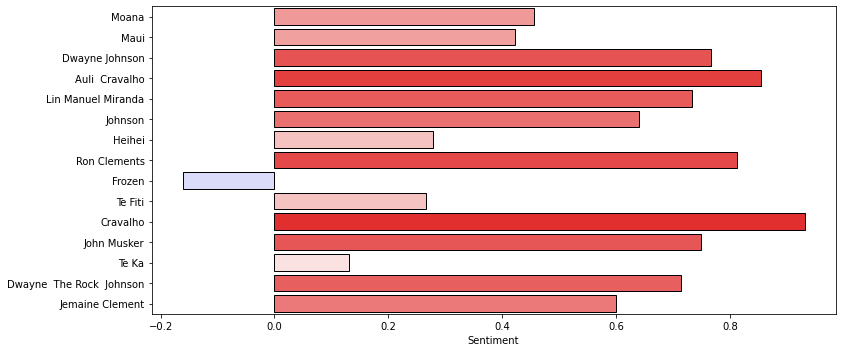

In [6]:
char.visualize_names(name = "Moana", people=True, save=None)

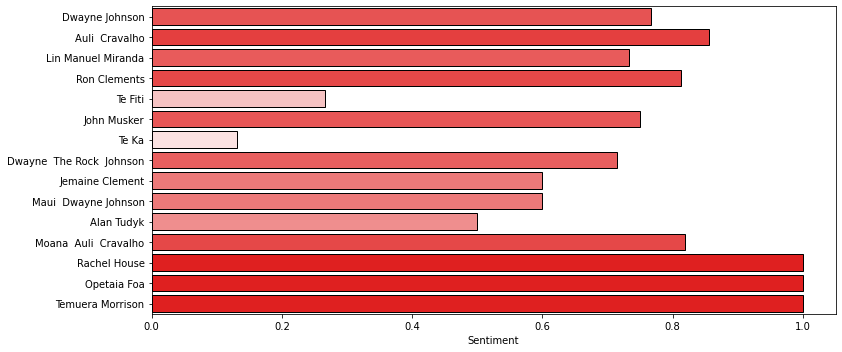

In [7]:
char.visualize_names(name = "Moana", people=True, save=None)